# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Build topic model

In [1]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [2]:
df = pd.read_parquet('hotels.parquet')

In [3]:
# tokenize using a list of terms we've found in 1-prepare
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

In [4]:
tokenizer.tokenize(df['text'].iloc[0])

['stayed',
 'in',
 'a',
 'king_suite',
 'for',
 '11',
 'nights',
 'and',
 'yes',
 'it',
 'cots',
 'us',
 'a',
 'bit',
 'but',
 'we',
 'were',
 'happy',
 'with',
 'the',
 'standard',
 'of',
 'room',
 'the',
 'location',
 'and',
 'the',
 'friendliness',
 'of',
 'the',
 'staff',
 'our',
 'room',
 'was',
 'on',
 'the',
 '20th',
 'floor',
 'overlooking',
 'broadway',
 'and',
 'the',
 'madhouse',
 'of',
 'the',
 'fairway',
 'market',
 'room',
 'was',
 'quite',
 'with',
 'no',
 'noise',
 'evident',
 'from',
 'the',
 'hallway',
 'or',
 'adjoining',
 'rooms',
 'it',
 'was',
 'great',
 'to',
 'be',
 'able',
 'to',
 'open',
 'windows',
 'when',
 'we',
 'craved',
 'fresh',
 'rather',
 'than',
 'heated',
 'air',
 'the',
 'beds',
 'including',
 'the',
 'fold',
 'out',
 'sofa_bed',
 'were',
 'comfortable',
 'and',
 'the',
 'rooms',
 'were',
 'cleaned',
 'well',
 'wi-fi',
 'access',
 'worked',
 'like',
 'a',
 'dream',
 'with',
 'only',
 'one',
 'connectivity',
 'issue',
 'on',
 'our',
 'first_night',


Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [5]:
subdf = df.sample(50000)

In [6]:
subdf['tokens'] = pd.Series(subdf['text'].progress_apply(tokenizer.tokenize))

  0%|          | 0/50000 [00:00<?, ?it/s]

### Estimate model

In [7]:
# use tomotopy to built model for topic 
import tomotopy as tp
import time

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

* *k* = number of topics
* *min_df* = minimum number of reviews that a term has to occur in to be included in the model
* *rm_top* = number of most frequent terms to remove from the model
* *tw* = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight)]
* *alpha*, *eta* = priors for document-topic and topic-word distributions
* *tol* = convergence tolerance


In [8]:
k = 100
min_df = 10  # remove less frequeny words
rm_top = 75  # remove 100 most frequency words like stop words
tw = tp.TermWeight.ONE
alpha = 0.1  
eta = 0.01
tol = 1e-3

Here's where we do the inference. The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [9]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in subdf['tokens']:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!')

    0 LL = -9.2910
   50 LL = -9.0398
  100 LL = -8.9470
  150 LL = -8.8963
  200 LL = -8.8678
  250 LL = -8.8468
  300 LL = -8.8353
  350 LL = -8.8268
  400 LL = -8.8218
  450 LL = -8.8169
  500 LL = -8.8138
  550 LL = -8.8100
  600 LL = -8.8085
  650 LL = -8.8054
  700 LL = -8.8036
  750 LL = -8.8042
Done!
CPU times: user 15min 53s, sys: 8.91 s, total: 16min 2s
Wall time: 5min 24s


### Evaluate the model

What terms are associated with each topic?

In [10]:
# list topics 
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  wedding, weekend, party, friends, guests, group, event, marathon, over, reception
  1  free, breakfast, drinks, embassy_suites, reception, evening, food, snacks, happy_hour, hot
  2  philadelphia, city, philly, hurricane, center, hall, historic, museum, square, warwick
  3  wine, evening, cookies, day, cheese, coffee, free, morning, breakfast, complimentary
  4  pool, gym, has, area, use, equipment, fitness_center, hot_tub, small, machines
  5  credit_card, charged, bill, charge, card, check, charges, after, them, days
  6  reviews, after, read, other, some, reading, booked, based, what, surprised
  7  westin, four, service, seasons, hotels, ritz, st., heavenly, starwood, property
  8  feel, home, wonderful, away, made, place, city, perfect, comfortable, lovely
  9  within, restaurants, walking_distance, located, close, many, friendly, shopping, comfortable, attractions
 10  tv, channels, desk, iron, bed, large, bathroom, microwave, fridge, comfortable
 11  beautiful, lobby, its, 

Which terms got remove due to `rm_top`?

In [11]:
# top most frequent words that we removed
', '.join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, at, room, were, that, but, on, this, with, very, you, had, have, there, my, are, our, from, they, as, so, stay, would, be, all, do, 's, rooms, if, one, staff, out, stayed, great, when, an, clean, no, us, which, nice, just, or, up, here, about, get, location, good, night, can, will, also, could, me, $, only, by, well, again, like, did"

Visualize topic model with LDAvis

In [12]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [13]:
pyLDAvis.display(prepared_data)

Find documents that best represent each topic

In [14]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(subdf['text'].iloc[d])
    print()

0 wedding, weekend, party, friends, guests, group, event, marathon, over, reception
We reserved over 20 rooms at this hotel. Since the wedding was at the Space Needle, we asked for rooms with views of the needle. All the rooms were perfect! We had brunch for 50 of our out of town guests the following day and it was fabulous. The set up was great and the food was super! Patricia was an excellent help in making decisions and was so supportive. Great place to stay and have an event.

1 free, breakfast, drinks, embassy_suites, reception, evening, food, snacks, happy_hour, hot
We enjoyed staying here for 5 nights. They provide 3 free drinks and dinner but the dinner is not worth having as it consists of baked potato and hot dogs and such ordinary foods. We tried their gin and tonic but we felt that the gin was not alcoholic. The gin was on tap which is very unusual! Breakfast was substantial.

2 philadelphia, city, philly, hurricane, center, hall, historic, museum, square, warwick
We had an

Generate word clouds for topics

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

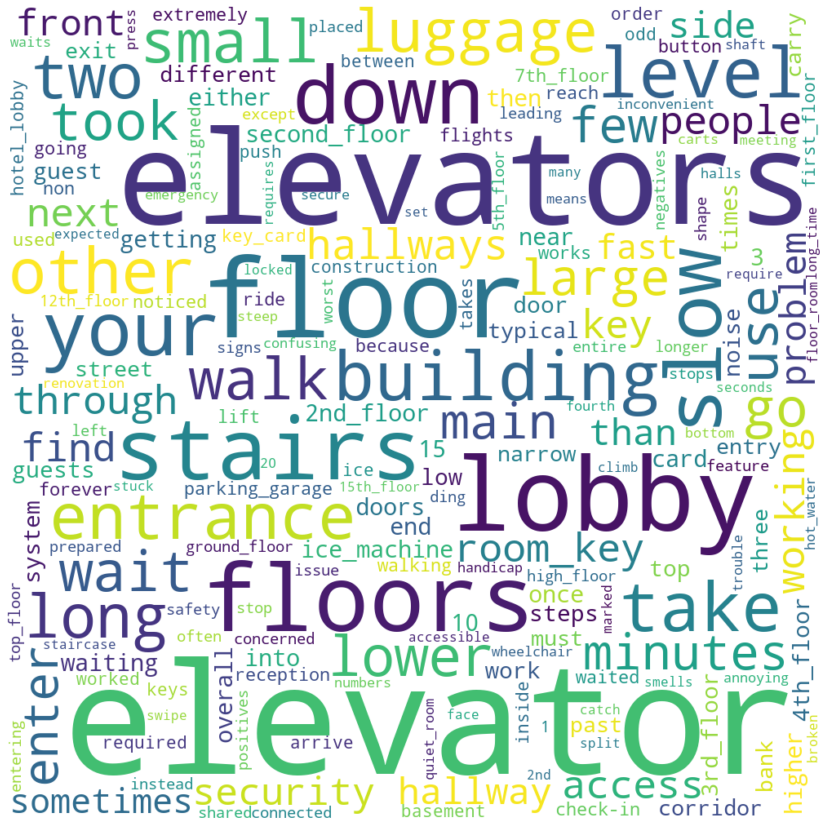

In [16]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(54, 200)) # top 200 words in topic 54
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Save the final, best model

In [17]:
mdl.save('hotel-topics.bin')